# BASE DE DADOS POLITICAS PÚBLICAS CEPAL 

## Importando as Bibliotecas

In [1]:
from selenium import webdriver
import requests
import time
import os
from pathlib import Path
import investpy as ipy # documentação: https://investpy.readthedocs.io/introduction.html
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from math import pi
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats  as stats
from scipy.stats import pearsonr
from sklearn import preprocessing
import seaborn as sns; sns.set()
from datetime import datetime
import calendar
import os
from os import listdir
from os.path import isfile, join
import plotly.graph_objects as go
pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

pd.options.display.float_format = '{:,.2f}'.format

## Pegar os códigos ISO de cada país

In [2]:
url = 'https://www.sport-histoire.fr/pt/Geografia/Paises_por_ordem_alfabetica.php'
html = requests.get(url).content
df_list = pd.read_html(html)
Pais_Continente = df_list[-1]
Pais_Continente
url = 'https://www.sport-histoire.fr/pt/Geografia/Codigos_ISO_Paises.php'
html = requests.get(url).content
df_list = pd.read_html(html)
Pais_ISO = df_list[-1]
America = Pais_ISO.merge(Pais_Continente)
lista = ['México','Venezuela','Argentina','Peru','Colômbia','Equador','Brasil','Chile','Uruguai','Bolívia']
selecao = America[America['País'].isin(lista)].reset_index(drop=True)
selecao = selecao['Código ISO (3 letras)']
selecao

0    ARG
1    BOL
2    BRA
3    CHL
4    COL
5    ECU
6    MEX
7    PER
8    URY
9    VEN
Name: Código ISO (3 letras), dtype: object

# Funções

## Criar função para verificar se o download do excel foi concluído

In [3]:
def download_wait(path_to_downloads):
    seconds = 0
    dl_wait = True
    while dl_wait and seconds < 10:
        time.sleep(0.2)
        dl_wait = False
        for fname in os.listdir(path_to_downloads):
            if fname.endswith('.xlsx'):
                dl_wait = True
        seconds += 1
    return seconds

## Definindo a função que seleciona a politica  para cada politica filho e neto

Nos referimos à política Pai como a política economica macro de um país dentre Política Fiscal, Política Monetária, e Política de Negócios (Classificação da CEPAL)

In [133]:
def retorna_politica_pai(EQ):
    EQ['General Policy']=EQ['Amount']
    nome=''
    for i in range(len(EQ['Policy'])):
        try:
            if type(EQ['Policy'].iloc[i]) == float:
                EQ['General Policy'].iloc[i]=nome
            elif EQ['Policy'].iloc[i].split()[0].split('.')[0].isnumeric() & (EQ['Policy'].iloc[i].split()[0].split('.')[1].isnumeric())!=True :
                nome=EQ['Policy'].iloc[i]
            else:
                EQ['General Policy'].iloc[i]=nome
        except IndexError:
                EQ['General Policy'].iloc[i]=nome

## Definindo a função que seleciona a politica filho para cada neto

In [119]:
def retorna_politica_filho(EQ):
    EQ['SubGeneral Policy']=EQ['Amount']
    nome=''
    for i in range(len(EQ['Policy'])):
        try:
            if EQ['Policy'].iloc[i].split()[0].split('.')[0].isnumeric() & (EQ['Policy'].iloc[i].split()[0].split('.')[1].isnumeric()):
                nome=EQ['Policy'].iloc[i]
            else:
                EQ['SubGeneral Policy'].iloc[i]=nome
        except IndexError:
            EQ['SubGeneral Policy'].iloc[i]=nome
        except AttributeError:
            EQ['SubGeneral Policy'].iloc[i]=nome
            

## Download das tabelas por país

In [9]:
#Abre em um chrome com diferentes caminhos para cada sistema peracional
home = Path.home()

#*************MODIFICAR O path_download PARA A PASTA DE DOWNLOAD DO SEU PC*************
path_download = Path(home,"Downloads")

path_win = '../Bases/evolution_of_COVID19_Measures/chromedriver.exe'
path_lin = '../Bases/evolution_of_COVID19_Measures/chromedriver_ln'
path_apple = '../Bases/evolution_of_COVID19_Measures/chromedriver'
driver = webdriver.Chrome(path_lin)
for i in selecao:
    link = 'https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country='+i+'&theme=3'
    print(link)
    driver.get(link)
    link = driver.find_element_by_id('btnExport')
    driver.implicitly_wait(10)
    link.click()

    download_wait(path_download)

https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=ARG&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=BOL&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=BRA&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=CHL&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=COL&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=ECU&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=MEX&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=PER&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=URY&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=VEN&theme=3


## Criando o dataframe bruto

In [149]:
#Deve-se alterar o nome do arquivo com a data que voce fez o download
home = Path.home()
EQ_new=pd.DataFrame()
lista = ['Mexico','Venezuela-Bol Rep. of','Argentina','Peru','Colombia','Ecuador','Brazil','Chile','Uruguay','Bolivia-Plur State of']
for pais in lista:
    EQ = pd.read_excel(Path(home,"Downloads","covid19_{}_23-10-2020.xlsx".format(pais)))
    EQ.columns = EQ.iloc[4]
    EQ.drop([0,1,2,3,4,5], axis=0, inplace=True)
    EQ.reset_index().drop('index',axis=1, inplace=True)
    EQ.columns=['Policy', 'Type', 'Date From', 'Date To', 'Authority', 'Amount', 'Unit', 'Currency', 'Financing Source', 'Link']
    retorna_politica_pai(EQ)
    EQ = EQ[EQ['General Policy'].notna()]
    EQ.drop(EQ.tail(2).index,inplace=True)
    retorna_politica_filho(EQ)
    EQ = EQ[EQ['SubGeneral Policy'].notna()]
    EQ['país'] = EQ['Policy'].apply(lambda a: pais)
    EQ_new=EQ_new.append(EQ, ignore_index=True)
EQ_new['Date From']=pd.to_datetime(EQ_new['Date From'],format='%Y-%m-%d')
EQ_new['Date To']=pd.to_datetime(EQ_new['Date To'],format='%Y-%m-%d')
EQ_new=EQ_new[(EQ_new['General Policy']=='1. Fiscal Policy') | (EQ_new['General Policy']=='2. Monetary Policy') | 
              (EQ_new['General Policy']=='3. Business policy')]

## Criando os DF's por política

In [151]:
fiscal_policy = EQ_new[EQ_new['General Policy']=='1. Fiscal Policy']
monetary_policy = EQ_new[EQ_new['General Policy']=='2. Monetary Policy']
business_policy = EQ_new[EQ_new['General Policy']=='3. Business policy']
restrictions_policy = EQ_new[EQ_new['General Policy']=='4. Restriction of economic activity (including shops and shopping centers)']


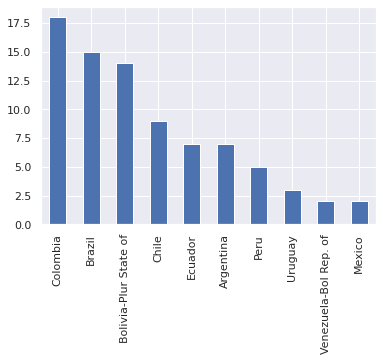

In [161]:
fiscal_policy['país'].value_counts().plot(kind='bar')

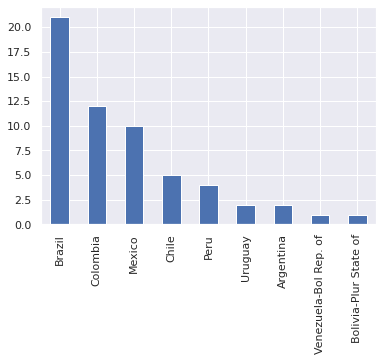

In [162]:
monetary_policy['país'].value_counts().plot(kind='bar')

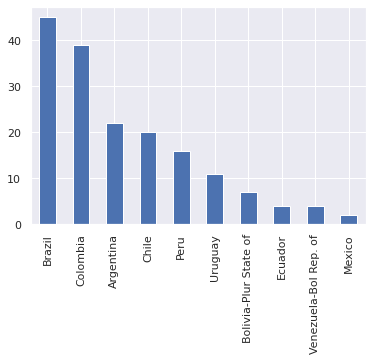

In [163]:
business_policy['país'].value_counts().plot(kind='bar')